In [33]:
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())

True


## Train, Test set
загрузим изображения и поделим на выборки

In [20]:
data_dir = "dataset"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

print(f"Всего изображений: {len(image_files)}, Всего масок: {len(mask_files)}")

train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=52)

print(f"Обучающих изображений: {len(train_images)}, Тестовых изображений: {len(test_images)}")

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.15, random_state=52)

print(f"Итогово: Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

Всего изображений: 2000, Всего масок: 2000
Обучающих изображений: 1600, Тестовых изображений: 400
Итогово: Train: 1360, Val: 240, Test: 400


## Зафиксируем рандом

In [21]:
SEED = 52
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# фиксируем настройки CUDA для воспроизводимости
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Метрика Jaccard (IoU)

In [22]:
def iou_score(pred_mask: torch.Tensor, true_mask: torch.Tensor) -> float:
    pred_mask_bool = pred_mask.bool()
    true_mask_bool = true_mask.bool()

    intersection = (pred_mask_bool & true_mask_bool).float().sum(dim=(-1, -2))
    union = (pred_mask_bool | true_mask_bool).float().sum(dim=(-1, -2))

    # Чтобы избежать деления на 0, добавим epsilon к знаменателю
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Если на входе был батч, вернем среднее по батчу
    return iou.mean().item() if iou.ndim > 0 else iou.item()

## Модель U-Net

In [23]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=32):
        super(UNet, self).__init__()
        self.enc1 = self._conv_block(in_channels, base_filters)
        self.enc2 = self._conv_block(base_filters, base_filters * 2)
        self.enc3 = self._conv_block(base_filters * 2, base_filters * 4)
        self.enc4 = self._conv_block(base_filters * 4, base_filters * 8)
        self.bottom = self._conv_block(base_filters * 8, base_filters * 16)

        self.up4 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = self._conv_block(base_filters * 16, base_filters * 8)
        self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(base_filters * 2, base_filters)

        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def _pad_to_match(self, x, target):
        diff_y = target.size(2) - x.size(2)
        diff_x = target.size(3) - x.size(3)
        x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                      diff_y // 2, diff_y - diff_y // 2])
        return x

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))
        x4 = self.enc4(F.max_pool2d(x3, 2))
        x5 = self.bottom(F.max_pool2d(x4, 2))

        u4 = self.up4(x5)
        u4 = self._pad_to_match(u4, x4)
        d4 = self.dec4(torch.cat([u4, x4], dim=1))

        u3 = self.up3(d4)
        u3 = self._pad_to_match(u3, x3)
        d3 = self.dec3(torch.cat([u3, x3], dim=1))

        u2 = self.up2(d3)
        u2 = self._pad_to_match(u2, x2)
        d2 = self.dec2(torch.cat([u2, x2], dim=1))

        u1 = self.up1(d2)
        u1 = self._pad_to_match(u1, x1)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))

        return self.out_conv(d1)

model = UNet(in_channels=3, out_channels=1, base_filters=32)
print(model.out_conv)

Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))


## Проверка модели путем переобучения на маленьком батче


In [24]:
def load_image_mask(image_filename, mask_filename):
    img = Image.open(os.path.join(images_dir, image_filename)).convert("RGB")
    mask = Image.open(os.path.join(masks_dir, mask_filename)).convert("L")
    img_tensor = torch.FloatTensor(np.array(img) / 255.0)  # нормируем к [0,1]
    img_tensor = img_tensor.permute(2, 0, 1)  # канал, высота, ширина
    mask_tensor = torch.FloatTensor(np.array(mask) / 255.0)  # маска в [0,1]
    mask_tensor = mask_tensor.unsqueeze(0)  # добавляем канал
    return img_tensor, mask_tensor


# Берем первые 4 из train
small_train_imgs = train_images[:4]
small_train_masks = train_masks[:4]

batch_images = []
batch_masks = []
for img_file, mask_file in zip(small_train_imgs, small_train_masks):
    img_t, mask_t = load_image_mask(img_file, mask_file)
    batch_images.append(img_t)
    batch_masks.append(mask_t)
batch_images = torch.stack(batch_images)
batch_masks = torch.stack(batch_masks)

device = torch.device("cuda")
model = model.to(device)
batch_images = batch_images.to(device)
batch_masks = batch_masks.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

обучим

In [25]:
num_epochs = 500
batch_iou_list = []
batch_loss_list = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    outputs = model(batch_images)
    loss = criterion(outputs, batch_masks)
    loss.backward()
    optimizer.step()
    batch_loss_list.append(loss.item())

    if epoch % 10 == 0:
        preds = torch.sigmoid(outputs) >= 0.5
        iou_val = iou_score(preds.cpu(), batch_masks.cpu())
        print(f"Эпоха {epoch}: loss = {loss.item():.4f}, IoU = {iou_val:.4f}")
        batch_iou_list.append(iou_val)
        if iou_val > 0.98:
            print("Достигнуто IoU > 0.98 на обучающем батче, останавливаем обучение.")
            break

Эпоха 10: loss = 0.6822, IoU = 0.4089
Эпоха 20: loss = 0.6485, IoU = 0.3999
Эпоха 30: loss = 0.6024, IoU = 0.4350
Эпоха 40: loss = 0.6674, IoU = 0.4546
Эпоха 50: loss = 0.5490, IoU = 0.4608
Эпоха 60: loss = 0.5135, IoU = 0.3923
Эпоха 70: loss = 0.5307, IoU = 0.6992
Эпоха 80: loss = 0.3801, IoU = 0.7496
Эпоха 90: loss = 0.5218, IoU = 0.5843
Эпоха 100: loss = 0.4514, IoU = 0.7384
Эпоха 110: loss = 0.3562, IoU = 0.7872
Эпоха 120: loss = 0.2983, IoU = 0.7852
Эпоха 130: loss = 0.9089, IoU = 0.7233
Эпоха 140: loss = 0.4991, IoU = 0.7069
Эпоха 150: loss = 0.3372, IoU = 0.7688
Эпоха 160: loss = 0.4749, IoU = 0.7310
Эпоха 170: loss = 0.3628, IoU = 0.6653
Эпоха 180: loss = 0.3130, IoU = 0.7833
Эпоха 190: loss = 0.1870, IoU = 0.8688
Эпоха 200: loss = 0.1619, IoU = 0.8970
Эпоха 210: loss = 0.1311, IoU = 0.9201
Эпоха 220: loss = 0.0923, IoU = 0.9345
Эпоха 230: loss = 0.0588, IoU = 0.9522
Эпоха 240: loss = 0.0616, IoU = 0.9373
Эпоха 250: loss = 0.1062, IoU = 0.9225
Эпоха 260: loss = 0.0651, IoU = 0.

Проверка результатов

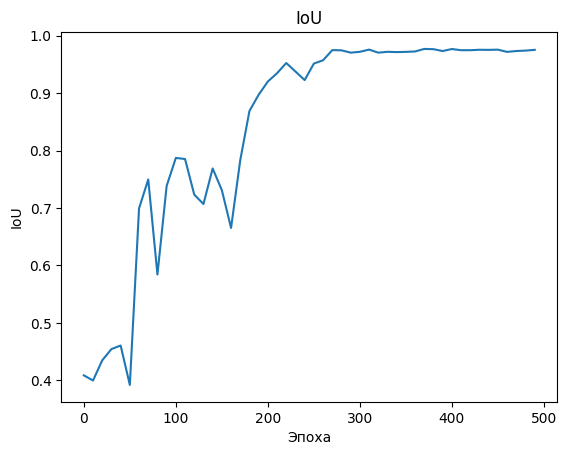

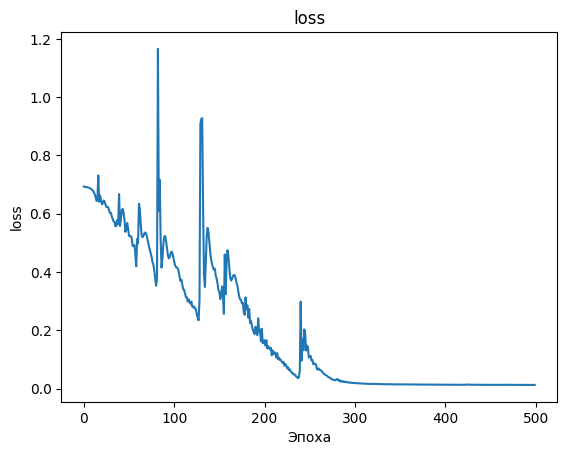

In [31]:
plt.figure()
plt.plot(range(0, 500, 10), batch_iou_list)
plt.title("IoU")
plt.xlabel("Эпоха")
plt.ylabel("IoU")
plt.show()

plt.figure()
plt.plot(batch_loss_list)
plt.title("loss")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.show()

In [27]:
model.eval()
with torch.no_grad():
    outputs = model(batch_images)
    preds = (torch.sigmoid(outputs) >= 0.5).float()
    train_iou = iou_score(preds.cpu(), batch_masks.cpu())
    print(f"IoU на 4 обучающих изображениях: {train_iou:.4f}")

    test_ious = []
    for img_file, mask_file in zip(test_images, test_masks):
        img_t, mask_t = load_image_mask(img_file, mask_file)
        img_t = img_t.unsqueeze(0).to(device)
        mask_t = mask_t.unsqueeze(0).to(device)
        out = model(img_t)
        pred_mask = (torch.sigmoid(out) >= 0.5).float()
        iou_val = iou_score(pred_mask.cpu(), mask_t.cpu())
        test_ious.append(iou_val)
    mean_test_iou = sum(test_ious) / len(test_ious)
    print(f"Средний IoU на тестовой выборке: {mean_test_iou:.4f}")

IoU на 4 обучающих изображениях: 0.9736
Средний IoU на тестовой выборке: 0.4789


### Результаты
Хоть на небольшой выборке и не были достигнуты прям идеальные результаты, но они все равно весьма неплохие и модель работает. Но результаты обученной так модели конечно оставляют желать лучшего. IoU и loss перестали улучшаться после 300 итераций.

## Полное обучение модели

In [58]:
class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        img = Image.open(os.path.join(self.images_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, mask_name)).convert("L")

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = torch.FloatTensor(img / 255.0).permute(2, 0, 1)  # [C,H,W]
        mask = torch.FloatTensor(mask / 255.0).unsqueeze(0)    # [1,H,W]
        return img, mask


train_dataset = SegmentationDataset(train_images, train_masks, images_dir, masks_dir, transform=None)
val_dataset   = SegmentationDataset(val_images, val_masks, images_dir, masks_dir, transform=None)
test_dataset  = SegmentationDataset(test_images, test_masks, images_dir, masks_dir, transform=None)

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=80, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import gc
del model, outputs, preds, loss
gc.collect()
torch.cuda.empty_cache()

model = UNet(in_channels=3, out_channels=1, base_filters=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 100
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

print("start")
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_iou = iou_score(preds.cpu(), masks.cpu())
        total_iou += batch_iou

    train_loss = total_loss / len(train_loader)
    train_iou = total_iou / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            batch_val_iou = iou_score(preds.cpu(), masks.cpu())
            total_val_iou += batch_val_iou
    val_loss = total_val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_iou = total_val_iou / len(val_loader) if len(val_loader) > 0 else 0


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)

    print(f"Эпоха {epoch}/{num_epochs} - Loss: {train_loss:.4f} (val {val_loss:.4f}), IoU: {train_iou:.4f} (val {val_iou:.4f})")


start
